In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import gym
import pathlib
import typing as tp
from scipy.special import softmax
import pandas as pd
import os

In [3]:
sys.path.insert(0, '/mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/codenames_ai/src')

In [4]:
from default_game import *
from codenames import *
from codenames_env import *

In [5]:
import stable_baselines3
from stable_baselines3.common import env_checker
from stable_baselines3 import DQN, SAC, PPO, A2C, HerReplayBuffer
import matplotlib.pyplot as plt

from stable_baselines3 import TD3
from stable_baselines3.common import results_plotter
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import BaseCallback, CallbackList

In [6]:
from stable_baselines3.common import env_checker

In [7]:
env_checker.check_env(CodenamesEnvHack(glove, wordlist))

/home/sherman/miniconda3/envs/fn_env/lib/python3.6/site-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your observation achieved_goal has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  f"Your observation {key} has an unconventional shape (neither an image, nor a 1D vector). "
/home/sherman/miniconda3/envs/fn_env/lib/python3.6/site-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your observation desired_goal has an unconventional shape (neither an image, nor a 1D vector). We recommend you to flatten the observation to have only a 1D vector or use a custom policy to properly process the data.
  f"Your observation {key} has an unconventional shape (neither an image, nor a 1D vector). "
/home/sherman/miniconda3/envs/fn_env/lib/python3.6/site-packages/stable_baselines3/common/env_checker.py:131: UserWarning: Your obs

In [57]:
from stable_baselines3.common.logger import configure
import pathlib

tmp_path = "/mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/sb3_log/"
# set up logger
new_logger = configure(tmp_path, ["stdout", "csv", "tensorboard"])
tmp_path_discrete = "/mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/sb3_log_discrete/"
# set up logger
new_logger_discrete = configure(tmp_path_discrete, ["stdout", "csv", "tensorboard"])

Logging to /mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/sb3_log/
Logging to /mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/sb3_log_discrete/


In [9]:
new_logger

In [58]:
def make_env(env_name):
    log_dir = pathlib.Path(tmp_path).joinpath(env_name)
    log_dir.mkdir(parents=True, exist_ok=True)
    return Monitor(CodenamesEnvHack(glove, wordlist), str(log_dir))

In [59]:
def make_env_discrete(env_name):
    log_dir = pathlib.Path(tmp_path_discrete).joinpath(env_name)
    return Monitor(CodenamesEnvHackDiscrete(glove, wordlist), str(log_dir))

In [60]:
def get_path_for(env_name, is_discrete=False):
    if is_discrete:
        return str(pathlib.Path(tmp_path_discrete).joinpath(env_name))
    return str(pathlib.Path(tmp_path).joinpath(env_name))

In [35]:
log_freq = 25000
num_train_steps = 1000000

In [61]:
n_sampled_goal = 4
models = dict(
    sac = SAC('MultiInputPolicy', make_env("sac"), verbose=1, target_update_interval=25),
    sac_her = SAC(
        'MultiInputPolicy',
        make_env("sac_her"),
        verbose=1, target_update_interval=25,
        replay_buffer_class=HerReplayBuffer,
        replay_buffer_kwargs=dict(
          n_sampled_goal=n_sampled_goal,
          goal_selection_strategy="future",
          # IMPORTANT: because the env is not wrapped with a TimeLimit wrapper
          # we have to manually specify the max number of steps per episode
          max_episode_length=25,
          online_sampling=True,
        ),
        buffer_size=int(1e6)
    ),
    ppo = PPO('MultiInputPolicy', make_env("ppo"), verbose=1, n_steps=25, n_epochs=80),
    a2c = A2C('MultiInputPolicy', make_env("a2c"), verbose=1, n_steps=25)
)

Using cuda device
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env in a DummyVecEnv.


In [62]:
models_discrete = dict(
    sac = SAC('MultiInputPolicy', make_env_discrete("sac"), verbose=1, target_update_interval=25),
    sac_her = SAC(
        'MultiInputPolicy',
        make_env_discrete("sac_her"),
        verbose=1, target_update_interval=25,
        replay_buffer_class=HerReplayBuffer,
        replay_buffer_kwargs=dict(
          n_sampled_goal=n_sampled_goal,
          goal_selection_strategy="future",
          # IMPORTANT: because the env is not wrapped with a TimeLimit wrapper
          # we have to manually specify the max number of steps per episode
          max_episode_length=25,
          online_sampling=True,
        ),
        buffer_size=int(1e6)
    ),
    ppo = PPO('MultiInputPolicy', make_env_discrete("ppo"), verbose=1, n_steps=25, n_epochs=80),
    a2c = A2C('MultiInputPolicy', make_env_discrete("a2c"), verbose=1, n_steps=25)
)

Using cuda device
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env in a DummyVecEnv.
Using cuda device
Wrapping the env in a DummyVecEnv.


In [18]:
# Separate env for evaluation
eval_env = CodenamesEnvHack(glove, wordlist)
eval_monitor = Monitor(eval_env)

# Random Agent, before training
mean_reward, std_reward = evaluate_policy(model, eval_monitor, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

NameError: name 'model' is not defined

In [19]:
# Separate env for evaluation
eval_env_discrete = CodenamesEnvHackDiscrete(glove, wordlist)
eval_monitor_discrete = Monitor(eval_env_discrete)
model_discrete = SAC('MultiInputPolicy', eval_monitor_discrete, verbose=1)

# Random Agent, before training
mean_reward_dc, std_reward_dc = evaluate_policy(model_discrete, eval_monitor_discrete, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward_dc:.2f} +/- {std_reward_dc}")

Using cuda device
Wrapping the env in a DummyVecEnv.
mean_reward=-32.40 +/- 5.4258639865002145


In [20]:
eval_monitor.episode_lengths

[]

In [21]:
np.mean([15, 16, 7, 4, 10, 2, 6, 5, 1, 8])

7.4

In [22]:
eval_monitor.get_episode_rewards()

[]

In [23]:
eval_monitor.episode_returns

[]

In [24]:
np.max(eval_monitor.episode_times)/len(eval_monitor.episode_times)

ValueError: zero-size array to reduction operation maximum which has no identity

In [25]:
from tqdm.auto import tqdm

class ProgressBarCallback(BaseCallback):
    """
    :param pbar: (tqdm.pbar) Progress bar object
    """
    def __init__(self, pbar):
        super(ProgressBarCallback, self).__init__()
        self._pbar = pbar

    def _on_step(self):
        # Update the progress bar:
        self._pbar.n = self.num_timesteps
        self._pbar.update(0)

# this callback uses the 'with' block, allowing for correct initialisation and destruction
class ProgressBarManager:
    def __init__(self, total_timesteps): # init object with total timesteps
        self.pbar = None
        self.total_timesteps = total_timesteps
        
    def __enter__(self): # create the progress bar and callback, return the callback
        self.pbar = tqdm(total=self.total_timesteps)
            
        return ProgressBarCallback(self.pbar)

    def __exit__(self, exc_type, exc_val, exc_tb): # close the callback
        self.pbar.n = self.total_timesteps
        self.pbar.update(0)
        self.pbar.close()

In [26]:
class SaveOnBestTrainingRewardCallback(BaseCallback):
    """
    Callback for saving a model (the check is done every ``check_freq`` steps)
    based on the training reward (in practice, we recommend using ``EvalCallback``).

    :param check_freq:
    :param log_dir: Path to the folder where the model will be saved.
      It must contains the file created by the ``Monitor`` wrapper.
    :param verbose: Verbosity level.
    """
    def __init__(self, check_freq: int, log_dir: str, verbose: int = 1):
        super(SaveOnBestTrainingRewardCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.log_dir = log_dir
        self.save_path = os.path.join(log_dir, 'best_model')
        self.best_mean_reward = -np.inf

    def _init_callback(self) -> None:
        # Create folder if needed
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:

          # Retrieve training reward
          try:
              x, y = ts2xy(load_results(self.log_dir), 'timesteps')
              if len(x) > 0:
                  # Mean training reward over the last 100 episodes
                  mean_reward = np.mean(y[-100:])
                  if self.verbose > 0:
                    print(f"Num timesteps: {self.num_timesteps}")
                    print(f"Best mean reward: {self.best_mean_reward:.2f} - Last mean reward per episode: {mean_reward:.2f}")

                  # New best model, you could save the agent here
                  if mean_reward > self.best_mean_reward:
                      self.best_mean_reward = mean_reward
                      # Example for saving best model
                      if self.verbose > 0:
                        print(f"Saving new best model to {self.save_path}")
                      self.model.save(self.save_path)
          except Exception:
            pass
        return True

In [47]:
class Run:
    def __init__(self, name, model, total_timesteps=1, mode="self_sim", num_eval_episodes=10, should_render=False, log_interval=500):
        assert mode in {"self_sim", "discrete"}
        print("Model:", name)
        self.log_dir = get_path_for(name, mode == "discrete")
        self.save_callback = SaveOnBestTrainingRewardCallback(check_freq=log_freq, log_dir=self.log_dir)
        self.logger = configure(get_path_for(name + "_logger", mode == "discrete"), ["stdout", "csv", "tensorboard"])
        print("Start training")
        model.set_logger(self.logger)
        with ProgressBarManager(total_timesteps) as progress_callback: # this the garanties that the tqdm progress bar closes correctly
            model.learn(total_timesteps=total_timesteps, log_interval=log_interval, callback=CallbackList([progress_callback, self.save_callback]))
        # Save the agent
        print("Saving...")
        model.save(f"{name}_codenames_hack_v0.0.1_end")
        # Evaluate the trained agent
        print("Evaluating...")
        if mode == "self_sim":
            self.eval_monitor_trained = make_env(name + "_eval")
        else:
            self.eval_monitor_trained = make_env_discrete(name + "_eval")
        mean_reward, std_reward = evaluate_policy(model, self.eval_monitor_trained, n_eval_episodes=num_eval_episodes, deterministic=True, render=should_render)
        print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")
        self.print_monitor_stat("Lengths", self.eval_monitor_trained.episode_lengths)
        self.print_monitor_stat("Returns", self.eval_monitor_trained.episode_returns)

    def print_monitor_stat(self, stat_name, stat):
        print(stat_name, stat, np.mean(stat), np.std(stat))

In [ ]:
runs = {k: Run(k, m, num_train_steps, should_render=True) for k, m in models.items()}

Model: sac
Logging to /mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/sb3_log/sac_logger
Start training


  0%|          | 0/1000000 [00:00<?, ?it/s]

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.1      |
|    ep_rew_mean     | -32.1    |
| time/              |          |
|    episodes        | 500      |
|    fps             | 83       |
|    time_elapsed    | 50       |
|    total_timesteps | 4253     |
| train/             |          |
|    actor_loss      | -157     |
|    critic_loss     | 131      |
|    ent_coef        | 0.35     |
|    ent_coef_loss   | -32.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4152     |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.77     |
|    ep_rew_mean     | -29.5    |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 82       |
|    time_elapsed    | 102      |
|    total_timesteps | 8482     |
| train/             |          |
|    actor_loss      | -622     |
|    critic_loss     | 3.19e+03 |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.65     |
|    ep_rew_mean     | -30.1    |
| time/              |          |
|    episodes        | 20000    |
|    fps             | 82       |
|    time_elapsed    | 2049     |
|    total_timesteps | 168681   |
| train/             |          |
|    actor_loss      | -455     |
|    critic_loss     | 2.98e+04 |
|    ent_coef        | 0.276    |
|    ent_coef_loss   | -2.11    |
|    learning_rate   | 0.0003   |
|    n_updates       | 168580   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.55     |
|    ep_rew_mean     | -30.8    |
| time/              |          |
|    episodes        | 20500    |
|    fps             | 82       |
|    time_elapsed    | 2102     |
|    total_timesteps | 173048   |
| train/             |          |
|    actor_loss      | -337     |
|    critic_loss     | 2.19e+04 |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.74     |
|    ep_rew_mean     | -29.5    |
| time/              |          |
|    episodes        | 30000    |
|    fps             | 82       |
|    time_elapsed    | 3071     |
|    total_timesteps | 253035   |
| train/             |          |
|    actor_loss      | -373     |
|    critic_loss     | 3.73e+04 |
|    ent_coef        | 0.222    |
|    ent_coef_loss   | -2.61    |
|    learning_rate   | 0.0003   |
|    n_updates       | 252934   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.96     |
|    ep_rew_mean     | -29.7    |
| time/              |          |
|    episodes        | 30500    |
|    fps             | 82       |
|    time_elapsed    | 3123     |
|    total_timesteps | 257324   |
| train/             |          |
|    actor_loss      | -704     |
|    critic_loss     | 4.68e+04 |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.28     |
|    ep_rew_mean     | -30.3    |
| time/              |          |
|    episodes        | 40500    |
|    fps             | 82       |
|    time_elapsed    | 4144     |
|    total_timesteps | 341483   |
| train/             |          |
|    actor_loss      | -496     |
|    critic_loss     | 9.85e+04 |
|    ent_coef        | 0.23     |
|    ent_coef_loss   | -4.66    |
|    learning_rate   | 0.0003   |
|    n_updates       | 341382   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.54     |
|    ep_rew_mean     | -30.8    |
| time/              |          |
|    episodes        | 41000    |
|    fps             | 82       |
|    time_elapsed    | 4198     |
|    total_timesteps | 345874   |
| train/             |          |
|    actor_loss      | -697     |
|    critic_loss     | 1.31e+05 |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



----------------------------------
| rollout/           |           |
|    ep_len_mean     | 9.25      |
|    ep_rew_mean     | -29.8     |
| time/              |           |
|    episodes        | 50000     |
|    fps             | 82        |
|    time_elapsed    | 5128      |
|    total_timesteps | 422246    |
| train/             |           |
|    actor_loss      | -1.31e+03 |
|    critic_loss     | 3.37e+05  |
|    ent_coef        | 0.311     |
|    ent_coef_loss   | 10.5      |
|    learning_rate   | 0.0003    |
|    n_updates       | 422145    |
----------------------------------
Num timesteps: 425000
Best mean reward: -29.23 - Last mean reward per episode: -31.21
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 7.95      |
|    ep_rew_mean     | -30.4     |
| time/              |           |
|    episodes        | 50500     |
|    fps             | 82        |
|    time_elapsed    | 5180      |
|    total_timesteps | 426530    |
| tr

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.42     |
|    ep_rew_mean     | -30.2    |
| time/              |          |
|    episodes        | 59000    |
|    fps             | 82       |
|    time_elapsed    | 6049     |
|    total_timesteps | 498267   |
| train/             |          |
|    actor_loss      | -475     |
|    critic_loss     | 3.09e+05 |
|    ent_coef        | 0.287    |
|    ent_coef_loss   | -2.62    |
|    learning_rate   | 0.0003   |
|    n_updates       | 498166   |
---------------------------------
Num timesteps: 500000
Best mean reward: -29.23 - Last mean reward per episode: -29.58


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.68     |
|    ep_rew_mean     | -30.4    |
| time/              |          |
|    episodes        | 60500    |
|    fps             | 82       |
|    time_elapsed    | 6205     |
|    total_timesteps | 511183   |
| train/             |          |
|    actor_loss      | -631     |
|    critic_loss     | 1.95e+05 |
|    ent_coef        | 0.207    |
|    ent_coef_loss   | 2.79     |
|    learning_rate   | 0.0003   |
|    n_updates       | 511082   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.36     |
|    ep_rew_mean     | -31.4    |
| time/              |          |
|    episodes        | 61000    |
|    fps             | 82       |
|    time_elapsed    | 6255     |
|    total_timesteps | 515310   |
| train/             |          |
|    actor_loss      | -779     |
|    critic_loss     | 1.8e+05  |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



----------------------------------
| rollout/           |           |
|    ep_len_mean     | 8.11      |
|    ep_rew_mean     | -30.1     |
| time/              |           |
|    episodes        | 68500     |
|    fps             | 82        |
|    time_elapsed    | 7026      |
|    total_timesteps | 578896    |
| train/             |           |
|    actor_loss      | -1.06e+03 |
|    critic_loss     | 2.55e+05  |
|    ent_coef        | 0.274     |
|    ent_coef_loss   | 7.47      |
|    learning_rate   | 0.0003    |
|    n_updates       | 578795    |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 9.08      |
|    ep_rew_mean     | -30.6     |
| time/              |           |
|    episodes        | 69000     |
|    fps             | 82        |
|    time_elapsed    | 7076      |
|    total_timesteps | 583078    |
| train/             |           |
|    actor_loss      | -1.71e+03 |
|    critic_loss    

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.89     |
|    ep_rew_mean     | -29.4    |
| time/              |          |
|    episodes        | 70500    |
|    fps             | 82       |
|    time_elapsed    | 7229     |
|    total_timesteps | 595721   |
| train/             |          |
|    actor_loss      | -391     |
|    critic_loss     | 3.52e+05 |
|    ent_coef        | 0.207    |
|    ent_coef_loss   | 2.02     |
|    learning_rate   | 0.0003   |
|    n_updates       | 595620   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.56     |
|    ep_rew_mean     | -29.3    |
| time/              |          |
|    episodes        | 78500    |
|    fps             | 82       |
|    time_elapsed    | 8047     |
|    total_timesteps | 663303   |
| train/             |          |
|    actor_loss      | -698     |
|    critic_loss     | 4.67e+05 |
|    ent_coef        | 0.316    |
|    ent_coef_loss   | 11.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 663202   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Num timesteps: 675000
Best mean reward: -28.68 - Last mean reward per episode: -31.10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.37     |
|    ep_rew_mean     | -30.6    |
| time/              |          |
|    episodes        | 80000    |
|    fps             | 82       |
|    time_elapsed    | 8200     |
|    total_timesteps | 675870   |
| train/             |          |
|    actor_loss      | -606     |
|    critic_loss     | 5.79e+05 |
|    ent_coef        | 0.189    |
|    ent_coef_loss   | -12.4    |
|    learning_rate   | 0.0003   |
|    n_updates       | 675769   |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 8.43      |
|    ep_rew_mean     | -31.2     |
| time/              |           |
|    episodes        | 80500     |
|    fps             | 82        |
|    time_elapsed    | 8252      |
|    total_timesteps | 680104    |
| train/             

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.72     |
|    ep_rew_mean     | -30.7    |
| time/              |          |
|    episodes        | 88000    |
|    fps             | 82       |
|    time_elapsed    | 9030     |
|    total_timesteps | 744125   |
| train/             |          |
|    actor_loss      | -223     |
|    critic_loss     | 2.93e+04 |
|    ent_coef        | 0.357    |
|    ent_coef_loss   | -25.8    |
|    learning_rate   | 0.0003   |
|    n_updates       | 744024   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.08     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 89500    |
|    fps             | 82       |
|    time_elapsed    | 9187     |
|    total_timesteps | 757088   |
| train/             |          |
|    actor_loss      | -582     |
|    critic_loss     | 1.53e+05 |
|    ent_coef        | 0.235    |
|    ent_coef_loss   | -0.0202  |
|    learning_rate   | 0.0003   |
|    n_updates       | 756987   |
---------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 8.5       |
|    ep_rew_mean     | -29.2     |
| time/              |           |
|    episodes        | 90000     |
|    fps             | 82        |
|    time_elapsed    | 9237      |
|    total_timesteps | 761248    |
| train/             |           |
|    actor_loss      | -1.93e+03 |
|    critic_loss     | 1.27e+06  |
| 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.45     |
|    ep_rew_mean     | -29.4    |
| time/              |          |
|    episodes        | 97500    |
|    fps             | 82       |
|    time_elapsed    | 10010    |
|    total_timesteps | 824802   |
| train/             |          |
|    actor_loss      | -623     |
|    critic_loss     | 3.09e+05 |
|    ent_coef        | 0.279    |
|    ent_coef_loss   | -12.4    |
|    learning_rate   | 0.0003   |
|    n_updates       | 824701   |
---------------------------------
Num timesteps: 825000
Best mean reward: -28.68 - Last mean reward per episode: -29.12
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.57     |
|    ep_rew_mean     | -30.3    |
| time/              |          |
|    episodes        | 98000    |
|    fps             | 82       |
|    time_elapsed    | 10061    |
|    total_timesteps | 828959   |
| train/             |        

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



----------------------------------
| rollout/           |           |
|    ep_len_mean     | 7.78      |
|    ep_rew_mean     | -30.5     |
| time/              |           |
|    episodes        | 99500     |
|    fps             | 82        |
|    time_elapsed    | 10214     |
|    total_timesteps | 841529    |
| train/             |           |
|    actor_loss      | -2.84e+03 |
|    critic_loss     | 1.67e+06  |
|    ent_coef        | 1.03      |
|    ent_coef_loss   | -1.21     |
|    learning_rate   | 0.0003    |
|    n_updates       | 841428    |
----------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.22     |
|    ep_rew_mean     | -30.5    |
| time/              |          |
|    episodes        | 107000   |
|    fps             | 82       |
|    time_elapsed    | 10992    |
|    total_timesteps | 905555   |
| train/             |          |
|    actor_loss      | -256     |
|    critic_loss     | 2.39e+05 |
|    ent_coef        | 0.153    |
|    ent_coef_loss   | -12.7    |
|    learning_rate   | 0.0003   |
|    n_updates       | 905454   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.98     |
|    ep_rew_mean     | -30      |
| time/              |          |
|    episodes        | 107500   |
|    fps             | 82       |
|    time_elapsed    | 11045    |
|    total_timesteps | 909885   |
| train/             |          |
|    actor_loss      | -519     |
|    critic_loss     | 2.44e+05 |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.92     |
|    ep_rew_mean     | -30.4    |
| time/              |          |
|    episodes        | 109000   |
|    fps             | 82       |
|    time_elapsed    | 11198    |
|    total_timesteps | 922409   |
| train/             |          |
|    actor_loss      | -259     |
|    critic_loss     | 5.19e+05 |
|    ent_coef        | 0.152    |
|    ent_coef_loss   | -4.65    |
|    learning_rate   | 0.0003   |
|    n_updates       | 922308   |
---------------------------------
Num timesteps: 925000
Best mean reward: -28.68 - Last mean reward per episode: -31.04
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.38     |
|    ep_rew_mean     | -30.4    |
| time/              |          |
|    episodes        | 109500   |
|    fps             | 82       |
|    time_elapsed    | 11248    |
|    total_timesteps | 926555   |
| train/             |        

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



----------------------------------
| rollout/           |           |
|    ep_len_mean     | 7.52      |
|    ep_rew_mean     | -30       |
| time/              |           |
|    episodes        | 117000    |
|    fps             | 82        |
|    time_elapsed    | 12013     |
|    total_timesteps | 989410    |
| train/             |           |
|    actor_loss      | -1.35e+03 |
|    critic_loss     | 7.01e+05  |
|    ent_coef        | 0.121     |
|    ent_coef_loss   | 25.9      |
|    learning_rate   | 0.0003    |
|    n_updates       | 989309    |
----------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.06     |
|    ep_rew_mean     | -31.3    |
| time/              |          |
|    episodes        | 500      |
|    fps             | 75       |
|    time_elapsed    | 54       |
|    total_timesteps | 4129     |
| train/             |          |
|    actor_loss      | -203     |
|    critic_loss     | 82.1     |
|    ent_coef        | 0.307    |
|    ent_coef_loss   | -89.7    |
|    learning_rate   | 0.0003   |
|    n_updates       | 4028     |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.95     |
|    ep_rew_mean     | -30.4    |
| time/              |          |
|    episodes        | 7500     |
|    fps             | 72       |
|    time_elapsed    | 872      |
|    total_timesteps | 63678    |
| train/             |          |
|    actor_loss      | 41.5     |
|    critic_loss     | 0.487    |
|    ent_coef        | 0.00189  |
|    ent_coef_loss   | -68.6    |
|    learning_rate   | 0.0003   |
|    n_updates       | 63577    |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.33     |
|    ep_rew_mean     | -31.6    |
| time/              |          |
|    episodes        | 8000     |
|    fps             | 73       |
|    time_elapsed    | 930      |
|    total_timesteps | 67925    |
| train/             |          |
|    actor_loss      | 45.6     |
|    critic_loss     | 0.45     |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.91     |
|    ep_rew_mean     | -31.2    |
| time/              |          |
|    episodes        | 15500    |
|    fps             | 73       |
|    time_elapsed    | 1803     |
|    total_timesteps | 131742   |
| train/             |          |
|    actor_loss      | 89.8     |
|    critic_loss     | 0.732    |
|    ent_coef        | 0.00192  |
|    ent_coef_loss   | -21.3    |
|    learning_rate   | 0.0003   |
|    n_updates       | 131641   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.14     |
|    ep_rew_mean     | -30.1    |
| time/              |          |
|    episodes        | 17000    |
|    fps             | 73       |
|    time_elapsed    | 1976     |
|    total_timesteps | 144334   |
| train/             |          |
|    actor_loss      | 94.9     |
|    critic_loss     | 0.722    |
|    ent_coef        | 0.00139  |
|    ent_coef_loss   | -20.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 144233   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.39     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 24000    |
|    fps             | 72       |
|    time_elapsed    | 2786     |
|    total_timesteps | 203312   |
| train/             |          |
|    actor_loss      | 63.7     |
|    critic_loss     | 0.988    |
|    ent_coef        | 0.00105  |
|    ent_coef_loss   | 37.3     |
|    learning_rate   | 0.0003   |
|    n_updates       | 203211   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.4      |
|    ep_rew_mean     | -30.1    |
| time/              |          |
|    episodes        | 25500    |
|    fps             | 72       |
|    time_elapsed    | 2959     |
|    total_timesteps | 215830   |
| train/             |          |
|    actor_loss      | 62.7     |
|    critic_loss     | 0.862    |
|    ent_coef        | 0.000866 |
|    ent_coef_loss   | -55.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 215729   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.78     |
|    ep_rew_mean     | -30.3    |
| time/              |          |
|    episodes        | 26000    |
|    fps             | 72       |
|    time_elapsed    | 3018     |
|    total_timesteps | 220212   |
| train/             |          |
|    actor_loss      | 62.9     |
|    critic_loss     | 1.93     |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Num timesteps: 275000
Best mean reward: -29.53 - Last mean reward per episode: -29.93
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.81     |
|    ep_rew_mean     | -30.3    |
| time/              |          |
|    episodes        | 33000    |
|    fps             | 72       |
|    time_elapsed    | 3827     |
|    total_timesteps | 278627   |
| train/             |          |
|    actor_loss      | 58.9     |
|    critic_loss     | 1.91     |
|    ent_coef        | 0.00119  |
|    ent_coef_loss   | -5.51    |
|    learning_rate   | 0.0003   |
|    n_updates       | 278526   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.08     |
|    ep_rew_mean     | -29.6    |
| time/              |          |
|    episodes        | 34500    |
|    fps             | 72       |
|    time_elapsed    | 4000     |
|    total_timesteps | 291067   |
| train/             |          |
|    actor_loss      | 58.4     |
|    critic_loss     | 0.709    |
|    ent_coef        | 0.000597 |
|    ent_coef_loss   | 11.9     |
|    learning_rate   | 0.0003   |
|    n_updates       | 290966   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Num timesteps: 350000
Best mean reward: -29.53 - Last mean reward per episode: -31.51
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.66     |
|    ep_rew_mean     | -31.7    |
| time/              |          |
|    episodes        | 41500    |
|    fps             | 72       |
|    time_elapsed    | 4817     |
|    total_timesteps | 350134   |
| train/             |          |
|    actor_loss      | 72.1     |
|    critic_loss     | 3.22     |
|    ent_coef        | 0.000703 |
|    ent_coef_loss   | 24.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 350033   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.7      |
|    ep_rew_mean     | -30.9    |
| time/              |          |
|    episodes        | 43000    |
|    fps             | 72       |
|    time_elapsed    | 4994     |
|    total_timesteps | 362933   |
| train/             |          |
|    actor_loss      | 76.9     |
|    critic_loss     | 0.888    |
|    ent_coef        | 0.000394 |
|    ent_coef_loss   | -25      |
|    learning_rate   | 0.0003   |
|    n_updates       | 362832   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.11     |
|    ep_rew_mean     | -30.4    |
| time/              |          |
|    episodes        | 43500    |
|    fps             | 72       |
|    time_elapsed    | 5055     |
|    total_timesteps | 367251   |
| train/             |          |
|    actor_loss      | 75.3     |
|    critic_loss     | 0.757    |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Num timesteps: 425000
Best mean reward: -29.53 - Last mean reward per episode: -30.00
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.63     |
|    ep_rew_mean     | -30.6    |
| time/              |          |
|    episodes        | 50500    |
|    fps             | 72       |
|    time_elapsed    | 5867     |
|    total_timesteps | 426118   |
| train/             |          |
|    actor_loss      | 73.1     |
|    critic_loss     | 0.647    |
|    ent_coef        | 0.000343 |
|    ent_coef_loss   | -13.6    |
|    learning_rate   | 0.0003   |
|    n_updates       | 426017   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.6      |
|    ep_rew_mean     | -31.6    |
| time/              |          |
|    episodes        | 51500    |
|    fps             | 72       |
|    time_elapsed    | 5983     |
|    total_timesteps | 434531   |
| train/             |          |
|    actor_loss      | 84.2     |
|    critic_loss     | 1.75     |
|    ent_coef        | 0.000369 |
|    ent_coef_loss   | -82.2    |
|    learning_rate   | 0.0003   |
|    n_updates       | 434430   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.46     |
|    ep_rew_mean     | -31      |
| time/              |          |
|    episodes        | 52000    |
|    fps             | 72       |
|    time_elapsed    | 6039     |
|    total_timesteps | 438631   |
| train/             |          |
|    actor_loss      | 86.8     |
|    critic_loss     | 0.467    |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.31     |
|    ep_rew_mean     | -30.8    |
| time/              |          |
|    episodes        | 59000    |
|    fps             | 72       |
|    time_elapsed    | 6870     |
|    total_timesteps | 498405   |
| train/             |          |
|    actor_loss      | 92.9     |
|    critic_loss     | 2.24     |
|    ent_coef        | 0.000412 |
|    ent_coef_loss   | -37.1    |
|    learning_rate   | 0.0003   |
|    n_updates       | 498304   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.66     |
|    ep_rew_mean     | -29.9    |
| time/              |          |
|    episodes        | 60500    |
|    fps             | 72       |
|    time_elapsed    | 7041     |
|    total_timesteps | 510828   |
| train/             |          |
|    actor_loss      | 92.3     |
|    critic_loss     | 2.6      |
|    ent_coef        | 0.000399 |
|    ent_coef_loss   | -26.2    |
|    learning_rate   | 0.0003   |
|    n_updates       | 510727   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.76     |
|    ep_rew_mean     | -30.3    |
| time/              |          |
|    episodes        | 67500    |
|    fps             | 72       |
|    time_elapsed    | 7868     |
|    total_timesteps | 570223   |
| train/             |          |
|    actor_loss      | 74.1     |
|    critic_loss     | 0.59     |
|    ent_coef        | 0.000475 |
|    ent_coef_loss   | 88.6     |
|    learning_rate   | 0.0003   |
|    n_updates       | 570122   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.36     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 69000    |
|    fps             | 72       |
|    time_elapsed    | 8042     |
|    total_timesteps | 582750   |
| train/             |          |
|    actor_loss      | 74.8     |
|    critic_loss     | 1.22     |
|    ent_coef        | 0.000496 |
|    ent_coef_loss   | 74       |
|    learning_rate   | 0.0003   |
|    n_updates       | 582649   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.64     |
|    ep_rew_mean     | -31.4    |
| time/              |          |
|    episodes        | 69500    |
|    fps             | 72       |
|    time_elapsed    | 8102     |
|    total_timesteps | 587072   |
| train/             |          |
|    actor_loss      | 75.7     |
|    critic_loss     | 1.35     |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.69     |
|    ep_rew_mean     | -31.4    |
| time/              |          |
|    episodes        | 76000    |
|    fps             | 72       |
|    time_elapsed    | 8875     |
|    total_timesteps | 642360   |
| train/             |          |
|    actor_loss      | 73.2     |
|    critic_loss     | 0.308    |
|    ent_coef        | 0.000292 |
|    ent_coef_loss   | 80.1     |
|    learning_rate   | 0.0003   |
|    n_updates       | 642259   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.87     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 77500    |
|    fps             | 72       |
|    time_elapsed    | 9051     |
|    total_timesteps | 655001   |
| train/             |          |
|    actor_loss      | 75.8     |
|    critic_loss     | 0.533    |
|    ent_coef        | 0.000442 |
|    ent_coef_loss   | -37.8    |
|    learning_rate   | 0.0003   |
|    n_updates       | 654900   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.53     |
|    ep_rew_mean     | -30.5    |
| time/              |          |
|    episodes        | 78000    |
|    fps             | 72       |
|    time_elapsed    | 9111     |
|    total_timesteps | 659298   |
| train/             |          |
|    actor_loss      | 76.8     |
|    critic_loss     | 0.604    |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.79     |
|    ep_rew_mean     | -31      |
| time/              |          |
|    episodes        | 85000    |
|    fps             | 72       |
|    time_elapsed    | 9928     |
|    total_timesteps | 718060   |
| train/             |          |
|    actor_loss      | 79       |
|    critic_loss     | 0.376    |
|    ent_coef        | 0.00033  |
|    ent_coef_loss   | -169     |
|    learning_rate   | 0.0003   |
|    n_updates       | 717959   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 9.11     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 86000    |
|    fps             | 72       |
|    time_elapsed    | 10048    |
|    total_timesteps | 726692   |
| train/             |          |
|    actor_loss      | 79.9     |
|    critic_loss     | 1.14     |
|    ent_coef        | 0.000169 |
|    ent_coef_loss   | 8.28     |
|    learning_rate   | 0.0003   |
|    n_updates       | 726591   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.17     |
|    ep_rew_mean     | -30.2    |
| time/              |          |
|    episodes        | 86500    |
|    fps             | 72       |
|    time_elapsed    | 10108    |
|    total_timesteps | 730892   |
| train/             |          |
|    actor_loss      | 79.2     |
|    critic_loss     | 0.977    |
|    ent_coef 

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 7.6      |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 93500    |
|    fps             | 72       |
|    time_elapsed    | 10931    |
|    total_timesteps | 790059   |
| train/             |          |
|    actor_loss      | 81.9     |
|    critic_loss     | 0.701    |
|    ent_coef        | 0.000237 |
|    ent_coef_loss   | 142      |
|    learning_rate   | 0.0003   |
|    n_updates       | 789958   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Num timesteps: 800000
Best mean reward: -29.48 - Last mean reward per episode: -31.06
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.62     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 95000    |
|    fps             | 72       |
|    time_elapsed    | 11107    |
|    total_timesteps | 802763   |
| train/             |          |
|    actor_loss      | 81.7     |
|    critic_loss     | 0.544    |
|    ent_coef        | 0.000209 |
|    ent_coef_loss   | -71      |
|    learning_rate   | 0.0003   |
|    n_updates       | 802662   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.65     |
|    ep_rew_mean     | -30.6    |
| time/              |          |
|    episodes        | 101000   |
|    fps             | 72       |
|    time_elapsed    | 11816    |
|    total_timesteps | 853840   |
| train/             |          |
|    actor_loss      | 78.7     |
|    critic_loss     | 1.71     |
|    ent_coef        | 0.000178 |
|    ent_coef_loss   | 97.8     |
|    learning_rate   | 0.0003   |
|    n_updates       | 853739   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Num timesteps: 875000
Best mean reward: -29.48 - Last mean reward per episode: -29.94
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.08     |
|    ep_rew_mean     | -30.1    |
| time/              |          |
|    episodes        | 103500   |
|    fps             | 72       |
|    time_elapsed    | 12109    |
|    total_timesteps | 875036   |
| train/             |          |
|    actor_loss      | 83.2     |
|    critic_loss     | 0.644    |
|    ent_coef        | 0.000236 |
|    ent_coef_loss   | -85.6    |
|    learning_rate   | 0.0003   |
|    n_updates       | 874935   |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.71     |
|    ep_rew_mean     | -31      |
| time/              |          |
|    episodes        | 104000   |
|    fps             | 72       |
|    time_elapsed    | 12172    |
|    total_timesteps | 879538   |
| train/             |        

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.61     |
|    ep_rew_mean     | -30.1    |
| time/              |          |
|    episodes        | 109500   |
|    fps             | 72       |
|    time_elapsed    | 12820    |
|    total_timesteps | 926433   |
| train/             |          |
|    actor_loss      | 82.9     |
|    critic_loss     | 0.317    |
|    ent_coef        | 0.000182 |
|    ent_coef_loss   | 187      |
|    learning_rate   | 0.0003   |
|    n_updates       | 926332   |
---------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.61     |
|    ep_rew_mean     | -31.1    |
| time/              |          |
|    episodes        | 112000   |
|    fps             | 72       |
|    time_elapsed    | 13110    |
|    total_timesteps | 947513   |
| train/             |          |
|    actor_loss      | 83.4     |
|    critic_loss     | 1.12     |
|    ent_coef        | 0.000201 |
|    ent_coef_loss   | -41.3    |
|    learning_rate   | 0.0003   |
|    n_updates       | 947412   |
---------------------------------
Num timesteps: 950000
Best mean reward: -29.48 - Last mean reward per episode: -30.75
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 8.64     |
|    ep_rew_mean     | -30.9    |
| time/              |          |
|    episodes        | 112500   |
|    fps             | 72       |
|    time_elapsed    | 13168    |
|    total_timesteps | 951712   |
| train/             |        

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



Start training


  0%|          | 0/1000000 [00:00<?, ?it/s]

---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.62      |
|    ep_rew_mean          | -28.9     |
| time/                   |           |
|    fps                  | 38        |
|    iterations           | 500       |
|    time_elapsed         | 325       |
|    total_timesteps      | 12500     |
| train/                  |           |
|    approx_kl            | 0.7933129 |
|    clip_fraction        | 0.809     |
|    clip_range           | 0.2       |
|    entropy_loss         | -69.2     |
|    explained_variance   | 0.344     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.136    |
|    n_updates            | 39920     |
|    policy_gradient_loss | -0.142    |
|    std                  | 0.875     |
|    value_loss           | 14.3      |
---------------------------------------


IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



---------------------------------------
| rollout/                |           |
|    ep_len_mean          | 8.46      |
|    ep_rew_mean          | -30       |
| time/                   |           |
|    fps                  | 38        |
|    iterations           | 2500      |
|    time_elapsed         | 1626      |
|    total_timesteps      | 62500     |
| train/                  |           |
|    approx_kl            | 1.7341018 |
|    clip_fraction        | 0.928     |
|    clip_range           | 0.2       |
|    entropy_loss         | -44.6     |
|    explained_variance   | 0.531     |
|    learning_rate        | 0.0003    |
|    loss                 | -0.135    |
|    n_updates            | 199920    |
|    policy_gradient_loss | -0.148    |
|    std                  | 0.563     |
|    value_loss           | 2         |
---------------------------------------
Num timesteps: 75000
Best mean reward: -30.32 - Last mean reward per episode: -30.82
-----------------------------------

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



--------------------------------------
| rollout/                |          |
|    ep_len_mean          | 8.53     |
|    ep_rew_mean          | -29.8    |
| time/                   |          |
|    fps                  | 38       |
|    iterations           | 8500     |
|    time_elapsed         | 5541     |
|    total_timesteps      | 212500   |
| train/                  |          |
|    approx_kl            | 710.6088 |
|    clip_fraction        | 0.969    |
|    clip_range           | 0.2      |
|    entropy_loss         | 71.5     |
|    explained_variance   | 0.222    |
|    learning_rate        | 0.0003   |
|    loss                 | 0.000408 |
|    n_updates            | 679920   |
|    policy_gradient_loss | -0.164   |
|    std                  | 0.0651   |
|    value_loss           | 38       |
--------------------------------------
Num timesteps: 225000
Best mean reward: -30.32 - Last mean reward per episode: -29.73
Saving new best model to /mnt/ubuntu_data_hdd/school/mas

In [ ]:
runs_discrete = {k: Run(k, m, num_train_steps, mode="discrete", should_render=True) for k, m in models_discrete.items()}

Model: sac
Logging to /mnt/ubuntu_data_hdd/school/masters/uwaterloo/1b/cs885/project/codenames/sb3_log_discrete/sac_logger
Start training


  0%|          | 0/1000000 [00:00<?, ?it/s]

----------------------------------
| rollout/           |           |
|    ep_len_mean     | 9         |
|    ep_rew_mean     | -30.8     |
| time/              |           |
|    episodes        | 500       |
|    fps             | 84        |
|    time_elapsed    | 51        |
|    total_timesteps | 4329      |
| train/             |           |
|    actor_loss      | -2.27e+05 |
|    critic_loss     | 1.76e+10  |
|    ent_coef        | 113       |
|    ent_coef_loss   | -39.2     |
|    learning_rate   | 0.0003    |
|    n_updates       | 1004128   |
----------------------------------
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 8.03      |
|    ep_rew_mean     | -30.3     |
| time/              |           |
|    episodes        | 1000      |
|    fps             | 83        |
|    time_elapsed    | 99        |
|    total_timesteps | 8391      |
| train/             |           |
|    actor_loss      | -1.67e+05 |
|    critic_loss    

In [ ]:
print

In [108]:
# Train the agent
with ProgressBarManager(10) as pmodels_discretecallback: # this the garanties that the tqdm progress bar closes correctly
    model_ppo.learn(total_timesteps=1, callback=CallbackList([progress_callback]))
# Save the agent
model_sac.save("sac_codenames_hack_v0.0.1")

  0%|          | 0/10 [00:00<?, ?it/s]

--------------------------
| time/              |   |
|    fps             | 1 |
|    iterations      | 1 |
|    time_elapsed    | 1 |
|    total_timesteps | 2 |
--------------------------


In [59]:
# Evaluate the trained agent
eval_monitor_trained = Monitor(eval_env)
mean_reward, std_reward = evaluate_policy(model, eval_monitor_trained, n_eval_episodes=10, deterministic=True)

print(f"mean_reward={mean_reward:.2f} +/- {std_reward}")

/home/sherman/miniconda3/envs/fn_env/lib/python3.6/site-packages/stable_baselines3/common/evaluation.py:69: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  UserWarning,


mean_reward=-32.00 +/- 3.9749213828703582


In [158]:
print(eval_monitor.episode_lengths)

[15, 16, 7, 4, 10, 2, 6, 5, 1, 8]


In [159]:
print(eval_monitor.episode_returns)

[-39, -40, -31, -28, -34, -26, -30, -29, -25, -32]


In [160]:
print(eval_monitor.episode_times)

[9.813233137130737, 20.39705991744995, 25.02803874015808, 27.637056350708008, 34.15482449531555, 35.45982313156128, 39.39241051673889, 42.63814973831177, 43.291807651519775, 48.50733518600464]


In [ ]:
https://colab.research.google.com/github/Stable-Baselines-Team/rl-colab-notebooks/blob/master/monitor_training.ipynb#scrollTo=iaOPfOrwWEP4

In [67]:
class PlotHack:
    def visualise_overall_agent_results(self, agent_results, agent_name, show_mean_and_std_range=False, show_each_run=False,
                                        color=None, ax=None, title=None, y_limits=None):
        """Visualises the results for one agent"""
        assert isinstance(agent_results, list), "agent_results must be a list of lists, 1 set of results per list"
        assert isinstance(agent_results[0], list), "agent_results must be a list of lists, 1 set of results per list"
        assert bool(show_mean_and_std_range) ^ bool(show_each_run), "either show_mean_and_std_range or show_each_run must be true"
        if not ax: ax = plt.gca()
        if not color: color =  self.agent_to_color_group[agent_name]
        if show_mean_and_std_range:
            mean_minus_x_std, mean_results, mean_plus_x_std = self.get_mean_and_standard_deviation_difference_results(agent_results)
            x_vals = list(range(len(mean_results)))
            ax.plot(x_vals, mean_results, label=agent_name, color=color)
            ax.plot(x_vals, mean_plus_x_std, color=color, alpha=0.1)
            ax.plot(x_vals, mean_minus_x_std, color=color, alpha=0.1)
            ax.fill_between(x_vals, y1=mean_minus_x_std, y2=mean_plus_x_std, alpha=0.1, color=color)
        else:
            for ix, result in enumerate(agent_results):
                x_vals = list(range(len(agent_results[0])))
                plt.plot(x_vals, result, label=agent_name + "_{}".format(ix+1), color=color)
                color = self.get_next_color()

        ax.set_facecolor('xkcd:white')

        # Shrink current axis's height by 10% on the bottom
        box = ax.get_position()
        ax.set_position([box.x0, box.y0 + box.height * 0.05,
                         box.width, box.height * 0.95])

        # Put a legend below current axis
        ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15),
                  fancybox=True, shadow=True, ncol=3)

        if not title: title = self.environment_name

        ax.set_title(title, fontsize=15, fontweight='bold')
        ax.set_ylabel('Rolling Episode Scores')
        ax.set_xlabel('Episode Number')
        self.hide_spines(ax, ['right', 'top'])
        ax.set_xlim([0, x_vals[-1]])

        if y_limits is None: y_min, y_max = self.get_y_limits(agent_results)
        else: y_min, y_max = y_limits

        ax.set_ylim([y_min, y_max])

        if self.config.show_solution_score:
            self.draw_horizontal_line_with_label(ax, y_value=self.config.environment.get_score_to_win(), x_min=0,
                                        x_max=self.config.num_episodes_to_run * 1.02, label="Target \n score")

In [68]:
from stable_baselines3.common.monitor import load_results

In [69]:
from stable_baselines3.common import results_plotter

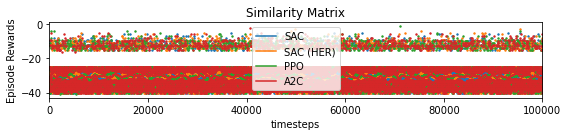

In [70]:
# Helper from the library
results_plotter.plot_results(
    [get_path_for("sac"), get_path_for("sac_her"), get_path_for("ppo"), get_path_for("a2c")],
    1e5, results_plotter.X_TIMESTEPS, "Similarity Matrix"
)
plt.legend(loc="best", labels=["SAC", "SAC (HER)", "PPO", "A2C"])

In [ ]:
# Helper from the library
tt = results_plotter.plot_results(
    [get_path_for("sac", True), get_path_for("sac_her", True), get_path_for("ppo", True), get_path_for("a2c", True)],
    1e5, results_plotter.X_TIMESTEPS, "Discrete"
)
plt.legend(loc="best", labels=["SAC", "SAC (HER)", "PPO", "A2C"])